In [1]:
#Descomprimir los datos
!rm -r mnist
!unzip mnist.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: mnist/train/5/2413.png  
  inflating: mnist/train/5/2445.png  
  inflating: mnist/train/5/2452.png  
  inflating: mnist/train/5/2460.png  
  inflating: mnist/train/5/2476.png  
  inflating: mnist/train/5/2487.png  
  inflating: mnist/train/5/2515.png  
  inflating: mnist/train/5/2518.png  
  inflating: mnist/train/5/2525.png  
  inflating: mnist/train/5/2526.png  
  inflating: mnist/train/5/2540.png  
  inflating: mnist/train/5/2545.png  
  inflating: mnist/train/5/2546.png  
  inflating: mnist/train/5/2554.png  
  inflating: mnist/train/5/2556.png  
  inflating: mnist/train/5/2558.png  
  inflating: mnist/train/5/2559.png  
  inflating: mnist/train/5/2569.png  
  inflating: mnist/train/5/2573.png  
  inflating: mnist/train/5/2574.png  
  inflating: mnist/train/5/2581.png  
  inflating: mnist/train/5/2586.png  
  inflating: mnist/train/5/2597.png  
  inflating: mnist/train/5/2604.png  
  inflating: mnist/train/5/

In [2]:
#Guardamos las direcciones de cada imagen

from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/1/6783.png'

In [3]:
# Reordenamos los datos de forma aleatoria
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [4]:
#Guardamos los datos de entrenamiento
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [5]:
#Guardamos los datos de validación
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [6]:
#Guardamos los datos de testeo
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

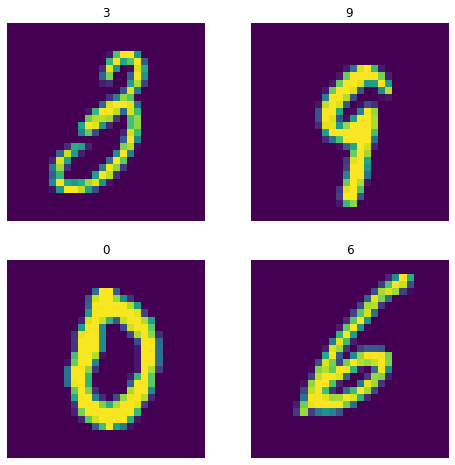

In [7]:
#Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [8]:
#Convetimos las listas a tensores
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [9]:
#Importamos y definimos la matriz de confusion

from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

In [10]:
from sklearn.metrics import f1_score

def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  CM(Y_valid, Y_pred, 10)

  0%|          | 0/1 [00:00<?, ?it/s]

ne: 50, hd:1000, wd:0.005, lr: 0.0005, bs:8 
Valid Evaluation loss: 0.23011523485183716. f1:0.9287419549141717 acc: 0.9290000200271606 


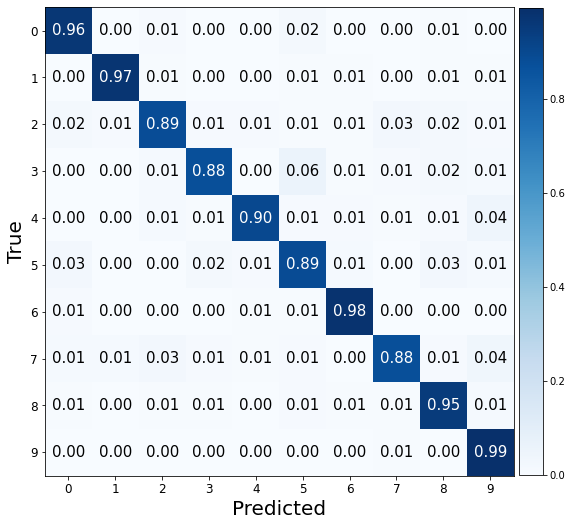

###################



In [37]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm


bs_list = [8]
lr_list = [0.0005]
wd_list = [0.005]
hd_list = [1000]
ne_list = [50]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        for hd in hd_list:
          input_dim = 28*28
          out_dim = 10
          hidden = hd

          model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, out_dim)
          )

          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
          criterion = torch.nn.CrossEntropyLoss()

          print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
          train_valid(model,ne,optimizer,criterion)
          print('###################\n')

          pbar.update()
pbar.close()

  0%|          | 0/1 [00:00<?, ?it/s]

ne: 50, hd:2000, wd:0.005, lr: 0.0005, bs:8 
Valid Evaluation loss: 0.24283179640769958. f1:0.9236954684613103 acc: 0.9240000247955322 


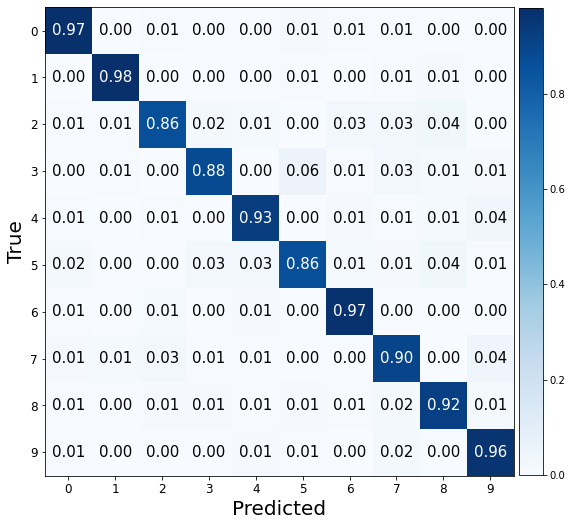

###################



In [47]:
bs_list = [8]
lr_list = [0.0005]
wd_list = [0.005]
hd_list = [2000]
ne_list = [50]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        for hd in hd_list:
          input_dim = 28*28
          out_dim = 10
          hidden = hd

          model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden, hidden),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden, out_dim)
          )

          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
          criterion = torch.nn.CrossEntropyLoss()

          print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
          train_valid(model,ne,optimizer,criterion)
          print('###################\n')

          pbar.update()
pbar.close()

# Análisis

Se realizaron dos redes muy similares, ambas de dos capas, únicamente cambiando su función de activación, en donde la primera era la función Relu y la segunda la función tanh. 

Los parámetros de la primera red, fueron cambiados todos, se probaron los siguientes valores: 

Para el número de épocas se probaron: [1, 10, 20, 30, 40, 50, 100, 200, 500, 1000]. En donde, para este problema y el tipo de redes planteadas, fue notorio que el incremento de las épocas también mejoraban las medidas de accuracy y f1, y disminuia la pérdida, tal como queríamos. Aún así, era considerable el aumento del tiempo de ejecucióm a medida que aumentabamos el número de épocas, y fue notrio que a partir de 50, el aumentar las épocas no aumentaba mejoraba lo suficiente los parámetros como para justificar el aumento en el tiempo de ejecución, por lo cual se seteo el número de capas en 50 para la primera red.

El learning rate también fue un parámetro importante, puesto que entre más cercano este era a 1, peor eran los parámetros de loss, f1 y acc, por lo cual se disminut¿yo lo más posible, en donde se eligió un valor de 0.0005, puesto que al disminuirlo más dichos parametros comenzaban a empeorar. Esto se cumplió tanto para la primera red como para la segunda, por lo que este número se dejó como óptimo para ambas.

Los casos del weigth decay y el batch size, fue notorio que los cambios drásticos no afectaban mucho los parámetros de loss, f1 y acc, por lo que se intento dejarlos lo mejor posible pero el cambio no fue del todo notorio. En el caso del weigth decay se intentaron los valores [0.1, 0.05, 0.01, 0.005], y se dejó el menor ya que con este se halló ligeramente mejor precisión, para ambas redes. Para el batch size se intentaron valores de [1, 8, 16, 32, 64, 128, 256, 512, 1024, 2048] y se notó que mejoraba ligeramente mientras más pequeño era el número, se dejo el valor de 8 para el caso de ambas redes.

Tanbién se jugó un poco con los valores de las neuronas escondidas, en donde aumentadolas todos los valores ejoraban considerablemente (caracteristica ya conocida de las clases anteriores).

A la hora de determinan cual de las dos configuraciones de las redes, fue clave observar entonces los parametros que si se variaron, que fueron la cantidad de neuronas escondidas y la cantidad de épocas, puesto que los demás permanecieron iguales. Se determinó así que la red de dos capas con función de activación relu, fue mejor que la red de dos capas con función de activación tanh, puesto que para valores iguales la primera fue mejor, y además, al intentar mejorar los meta parametros de la segunda red, necesito de el doble de neuronas (o de capas también) para alcanzar resultados similares, lo cual costaba considerablemente en el tiempo de ejución tardando casi el triple que la primera red. Adicionalmente, al observar la matriz de confusión se ve que si bien ambas son similares, la diagonal de la primera red presenta valores más altos cuando se usan los mismos parametros, y cuando se mejoran los de la segunda red, siguen siendo ligeramente mejores.

Finalmente se intentó añadir más capas a la segunda red para ver si esto mejoraba, se añadieron dos capas más también con tanh com función de activasión, pero los resultados fueron casi imperceptibles.

En conclusión, la función de activasión relu es más adecuada para este problema que la función tanh. Así mismo, los meta parametros de neuronas escondidas, épocas y learning rate son los más importantes al intentar conseguir una red neuronal con buenos valores de acc, f1 y poca pérdida. Los metaparámetros de weigth decay y el batch size resultaron no ser tan relevantes en comparación con los demás, al menos para el problema presentado.
